In [3]:
import pandas as pd

# 將每季累計的財務數據改成單季的數據
def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()


# 上一堂課教的：優等生策略

In [2]:
import pandas as pd

def mystrategy(data):
    
    股本 = data.get('股本合計', 1)#.drop_duplicates(['stock_id', 'date'], keep='last')#.pivot(index='date', columns='stock_id')
    price = data.get('收盤價', 200)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
    
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5
    
    return select_stock[select_stock]


**WARRN: data cannot be retrieve completely: 收盤價
2014-08-01 - 2014-09-30 報酬率: -4.38 % nstock 65
2014-09-30 - 2014-11-29 報酬率: -4.90 % nstock 97
2014-11-29 - 2015-01-28 報酬率: 9.35 % nstock 101
2015-01-28 - 2015-03-29 報酬率: 4.99 % nstock 97
2015-03-29 - 2015-05-28 報酬率: -1.20 % nstock 95
2015-05-28 - 2015-07-27 報酬率: -13.66 % nstock 64
2015-07-27 - 2015-09-25 報酬率: 2.40 % nstock 64
2015-09-25 - 2015-11-24 報酬率: 10.16 % nstock 81
2015-11-24 - 2016-01-23 報酬率: -4.01 % nstock 93
2016-01-23 - 2016-03-23 報酬率: 14.24 % nstock 94
2016-03-23 - 2016-05-22 報酬率: -8.59 % nstock 92
2016-05-22 - 2016-07-21 報酬率: 7.55 % nstock 108
2016-07-21 - 2016-09-19 報酬率: 2.01 % nstock 110
2016-09-19 - 2016-11-18 報酬率: -0.92 % nstock 111
2016-11-18 - 2017-01-17 報酬率: 5.54 % nstock 118
2017-01-17 - 2017-03-18 報酬率: 8.86 % nstock 120
2017-03-18 - 2017-05-17 報酬率: 0.01 % nstock 115
2017-05-17 - 2017-07-16 報酬率: 2.45 % nstock 76
2017-07-16 - 2017-09-14 報酬率: 8.15 % nstock 78
2017-09-14 - 2017-11-13 報酬率: 3.72 % nstock 64
2017-11-13 - 2

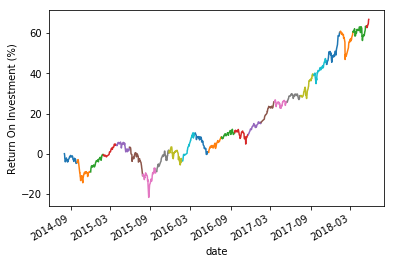

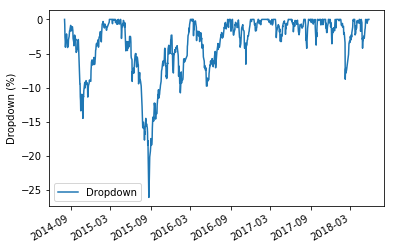

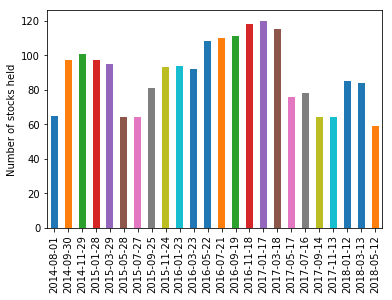

In [6]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime
%matplotlib inline

data = Data()
eq = backtest(datetime.date(2014,8,1), datetime.date(2018,5,25), 60, mystrategy, data)

### 回測

# 資優生策略

In [6]:
import pandas as pd

def mystrategy2(data):
    
    股本 = data.get('股本合計', 1)#.drop_duplicates(['stock_id', 'date'], keep='last')#.pivot(index='date', columns='stock_id')
    price = data.get('收盤價', 200)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
        
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    rsv = (price.iloc[-1] - price.iloc[-150:].min()) / (price.iloc[-150:].max() - price.iloc[-150:].min())
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 3
    condition6 = rsv > 0.5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5 & condition6
    
    return select_stock[select_stock]


### 回測

**WARRN: data cannot be retrieve completely: 收盤價
2014-08-01 - 2014-09-01 報酬率: -1.98 % nstock 44
2014-09-01 - 2014-10-02 報酬率: -4.89 % nstock 29
2014-10-02 - 2014-11-02 報酬率: -6.33 % nstock 17
2014-11-02 - 2014-12-03 報酬率: -0.55 % nstock 11
2014-12-03 - 2015-01-03 報酬率: 0.62 % nstock 24
2015-01-03 - 2015-02-03 報酬率: 5.88 % nstock 33
2015-02-03 - 2015-03-06 報酬率: 3.14 % nstock 41
2015-03-06 - 2015-04-06 報酬率: 2.49 % nstock 50
2015-04-06 - 2015-05-07 報酬率: -0.00 % nstock 33
2015-05-07 - 2015-06-07 報酬率: -4.88 % nstock 29
2015-06-07 - 2015-07-08 報酬率: -1.11 % nstock 21
2015-07-08 - 2015-08-08 報酬率: -10.47 % nstock 11
2015-08-08 - 2015-09-08 報酬率: 8.50 % nstock 5
2015-09-08 - 2015-10-09 報酬率: 7.64 % nstock 6
2015-10-09 - 2015-11-09 報酬率: 8.40 % nstock 23
2015-11-09 - 2015-12-10 報酬率: -0.08 % nstock 33
2015-12-10 - 2016-01-10 報酬率: 0.71 % nstock 32
2016-01-10 - 2016-02-10 報酬率: 5.99 % nstock 37
2016-02-10 - 2016-03-12 報酬率: 7.83 % nstock 42
2016-03-12 - 2016-04-12 報酬率: 0.60 % nstock 57
2016-04-12 - 2016-05-13

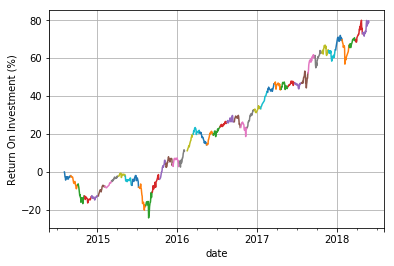

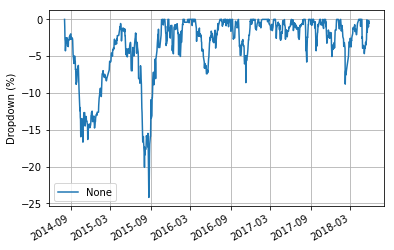

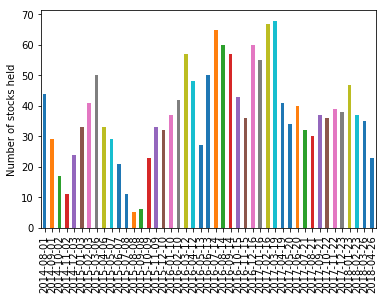

In [7]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

data = Data()

# 起始結束日期
start = datetime.date(2014, 8, 1)
end = datetime.date(2018, 5, 25)

# 課堂上教的回測
eq = backtest(start, end, 31, mystrategy2, data)